# 🧠 Feature Map Comparison for Hybrid Quantum Neural Networks (HQNN)

This experiment evaluates the performance of different quantum feature maps—**ZZFeatureMap**, **ZFeatureMap**, and **PauliFeatureMap**—within a Hybrid Quantum Neural Network model. Results are compared across all signal types (Bluetooth, WiFi, Zigbee) within `scenario_one` to assess how feature map choice impacts localization accuracy.

In [1]:
# Setup and Imports
import sys
sys.path.append("..")

import torch
from torch import nn, optim
from hqnn_core.qnn_builder import create_qnn
from hqnn_core.classical_model import ClassicalNN
from hqnn_core.hqnn_model import HybridModel
from hqnn_core.train import train_model
from hqnn_core.evaluate import evaluate_model
from hqnn_core.data_utils import load_rssi_dataset

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Experimental hyperparameters
num_qubits = 3
reps = 1
ansatz_type = "real"
learning_rate = 0.01
num_epochs = 15
batch_size = 16
sc_num = 1

# Feature maps to test
feature_maps = ["zz", "z", "pauli"]

# Scenarios and signal types to explore
scenarios = ["scenario_one"]
signals = ["bluetooth", "wifi", "zigbee"]

In [ ]:
# Training
results = []

for feature_map_type in feature_maps:
    for scenario in scenarios:
        for signal in signals:
            print(f"Training on {scenario.upper()} - {signal} using {feature_map_type.upper()} feature map...")

            train_loader, test_loader = load_rssi_dataset(
                scenario=scenario,
                signal=signal,
                sc_num=sc_num,
                batch_size=batch_size,
                base_path="../data"
            )

            # Create QNN + Classical components
            qnn = create_qnn(
                num_qubits=num_qubits,
                reps=reps,
                feature_map_type=feature_map_type,
                ansatz_type=ansatz_type
            )
            clnn = ClassicalNN(input_size=3, hidden_size=32, output_size=2)
            model = HybridModel(qnn, clnn)

            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, verbose=False)
            rmse = evaluate_model(model, test_loader)

            results.append({
                "Scenario": scenario,
                "Signal": signal,
                "FeatureMap": feature_map_type,
                "RMSE": rmse
            })

Training on SCENARIO_ONE - bluetooth using ZZ feature map...
✅ RMSE on test set: 2.1256
Training on SCENARIO_ONE - wifi using ZZ feature map...
✅ RMSE on test set: 1.7444
Training on SCENARIO_ONE - zigbee using ZZ feature map...
✅ RMSE on test set: 1.5777
Training on SCENARIO_ONE - bluetooth using Z feature map...
✅ RMSE on test set: 1.2539
Training on SCENARIO_ONE - wifi using Z feature map...
✅ RMSE on test set: 1.5757
Training on SCENARIO_ONE - zigbee using Z feature map...
✅ RMSE on test set: 1.8805
Training on SCENARIO_ONE - bluetooth using PAULI feature map...
✅ RMSE on test set: 1.6384
Training on SCENARIO_ONE - wifi using PAULI feature map...
✅ RMSE on test set: 1.4541
Training on SCENARIO_ONE - zigbee using PAULI feature map...
✅ RMSE on test set: 1.2964


In [ ]:
# Results
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
df_results

,Scenario,Signal,FeatureMap,RMSE
0,scenario_one,bluetooth,z,1.253902
1,scenario_one,zigbee,pauli,1.296385
2,scenario_one,wifi,pauli,1.454121
3,scenario_one,wifi,z,1.575707
4,scenario_one,zigbee,zz,1.577669
5,scenario_one,bluetooth,pauli,1.638427
6,scenario_one,wifi,zz,1.744358
7,scenario_one,zigbee,z,1.880480
8,scenario_one,bluetooth,zz,2.125551


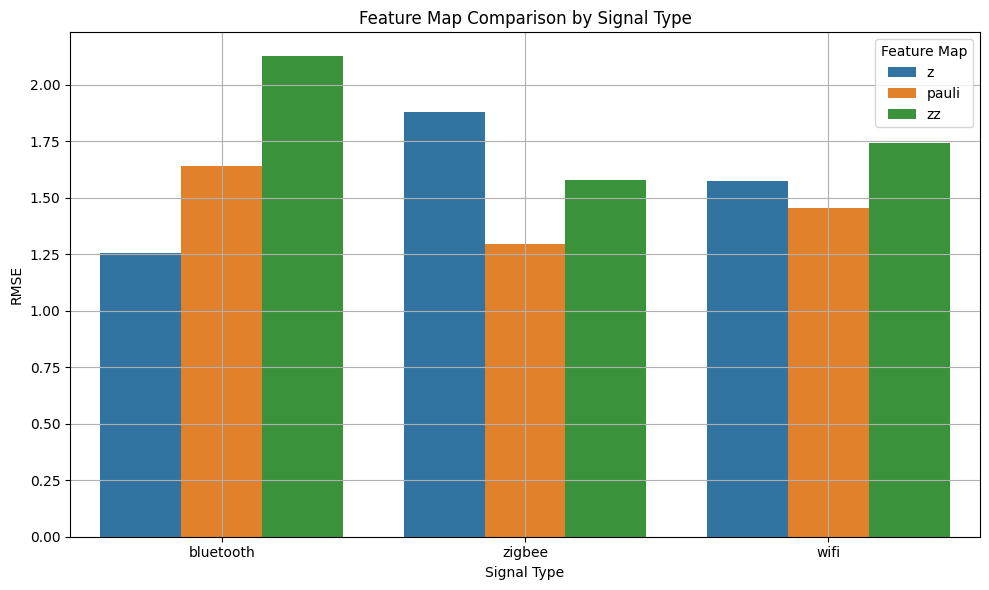

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Signal", y="RMSE", hue="FeatureMap")
plt.title("Feature Map Comparison by Signal Type")
plt.xlabel("Signal Type")
plt.ylabel("RMSE")
plt.legend(title="Feature Map")
plt.grid(True)
plt.tight_layout()
plt.show()